In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pathlib
import joblib
from typing import Tuple, List

In [2]:
## Self explanatory
save_plots = True

## Toggle plot titles (off for thesis and papers, generally speaking)
show_titles = False

## Toggle plot grid
show_grid = False

## Black and white?
black_and_white = True

## Drop event if DTF_FixJPsiLambda failed?
dtf_success = True

## Veto physical background
b0_veto = True

## Select signal region ([5508.5, 5731.8] MeV/c^2)
only_sig_region = True

In [3]:
saved_models = {
    ## BALANCE
    ## Higher overtraining. Slightly better performance in test (fractions of percentage)
    'sachiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.010,
        'max_leaf_nodes' : 200,
        'max_iter' : 5000,
        'soft_threshold': 0.7,
        'hard_threshold': 0.9924
    },
    ## Lower ovetraining. Looks better under K-S test. Slightly worse performance in test (fractions of percentage)
    'shamshel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.7,
        'hard_threshold': 0.985
    },
    ## BKGSKEW
    ## From an overtraining standpoint, this is the better one of the bkgskew
    'ramiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.656
    },
    ## This has quite more overtraining, but loses less signal
    'israfel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.015,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.714
    },
    ## Salvatore's HBDT, for performance comparison.
    ## Somewhat similar to israfel, does not match his original HBDT
    'sandalphon': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.01,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.637
    }
}

In [4]:
## Either one of the names in list(saved_models) or 'temp' for custom new model
model_to_use = 'shamshel'

if model_to_use in saved_models:
    daughter_momenta = saved_models[model_to_use]['daughter_momenta']
    dataset_type = saved_models[model_to_use]['dataset_type']
    training_params = {key: saved_models[model_to_use][key] for key in ['learning_rate', 'max_leaf_nodes', 'max_iter']}
    hard_threshold = saved_models[model_to_use]['hard_threshold']
elif model_to_use == 'temp':
    ## Proton and pion momenta
    ## 'VF': use VF momenta
    ## 'DTF': use DTF momenta w/ JPsi m.c.
    ## 'DTFL': use DTF momenta w/ JPsi and Lambda m.c.
    ## 'NO': don't use any momenta for Lambda daughter particles
    daughter_momenta = 'DTF'

    ## Two options:
    ## 'balance': same number of training events for signal and bkg
    ## 'bkgskew' uses 4 mln events of bkg, 500k of signal
    dataset_type = 'bkgskew'

    training_params = {
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 5000
    }
    
    hard_threshold = 0.9
else:
    raise ValueError

In [5]:
if dataset_type not in ['balance', 'bkgskew']:
    raise ValueError

In [6]:
if daughter_momenta == 'VF':
    p_momenta = ['p_PT', 'p_PZ']
    pim_momenta = ['pim_PT', 'pim_PZ']
elif daughter_momenta == 'DTF':
    p_momenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pim_momenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughter_momenta == 'DTFL':
    p_momenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pim_momenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughter_momenta == 'NO':
    p_momenta = []
    pim_momenta = []
else:
    raise ValueError(daughter_momenta + " is not a valid option for momenta usage.")

In [7]:
if dataset_type == 'balance':
    dataset_suffix = 'BAL'
else:
    dataset_suffix = 'SKEW'

classifier_dump_filename = (
    'HBDT_'
    + daughter_momenta
    + '_' + str(training_params['learning_rate'])
    + '_' + str(training_params['max_leaf_nodes'])
    + '_' + str(training_params['max_iter'])
    + '_' + dataset_suffix
)

classifier_dump_filename

'HBDT_DTF_0.003_100_2500_BAL'

In [8]:
## Create plots directory, if missing
repo_directory = str(pathlib.Path.home()) + '/lambda-emdm-measurement/'
state_directory = str(pathlib.Path.home()) + '/classifier-studies/' + '20_HBDT/' + 'saved_states/'

plot_directory = (
    repo_directory + 'plots/'
    + 'lambda_endvertex_study/'
)

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)

In [9]:
path_to_hd5_files = str(pathlib.Path.home()) + '/data/'
input_mc = path_to_hd5_files + 'LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'

# Data prepping
## Import Monte Carlo data

In [10]:
def p_modulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def transverse_p_modulus(px, py):
    return np.sqrt(px**2 + py**2)

In [11]:
df_reco = pd.read_hdf(input_mc, key='LHCbMC_Lb')
df_truth = pd.read_hdf(input_mc, key='LHCbMCTruth_Lb')
df_mc = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_mc = df_mc.loc[(df_mc['MC_key'] >= 0) & (df_mc['Rec_key'] >= 0)]

#del(df_reco, df_truth)
del(df_reco)

In [12]:
mag_down_bins = [(0, 1730000), (3500000, 4860000), (6200000, 7570000)]
mag_up_bins =  [(1730000, 3500000), (4860000, 6200000), (7570000, 10000000)]

for mag_bin in mag_up_bins:
    df_mc.loc[(df_mc['MC_key'] >= mag_bin[0]) & (df_mc['MC_key'] < mag_bin[1]), 'Polarity'] = +1
    
for mag_bin in mag_down_bins:
    df_mc.loc[(df_mc['MC_key'] >= mag_bin[0]) & (df_mc['MC_key'] < mag_bin[1]), 'Polarity'] = -1

In [13]:
jpsi_pdg_mass = 3096.900
b0_pdg_mass = 5279.61
b0_veto_threshold = 70

In [14]:
## Missing "combined" invariant masses (for Lambda->p pim and Lambdab->JPsi Lambda)
## These are the AM in the DaVinci config file. Did Salvatore implement them somewhere?

pion_p_cuts = (
    (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) > 2000)
    & (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) < 5e5)
)

proton_p_cuts = (
    (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) > 10000)
    & (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) < 5e5)
)

proton_pt_cuts = transverse_p_modulus(df_mc['p_PX'], df_mc['p_PY']) > 400

lambda_m_cuts = (df_mc['L_M'] > 600) & (df_mc['L_M'] < 1500)
lambda_mm_cuts = df_mc['L_MM'] < 1500
lambda_z_cuts = (df_mc['L_ENDVERTEX_Z'] > 5500) & (df_mc['L_ENDVERTEX_Z'] < 8500)
lambda_dira_cuts = df_mc['L_BPVDIRA'] > 0.9999
lambda_ipchi2_cuts = df_mc['L_BPVIPCHI2'] < 200
lambda_vdchi2_cuts = df_mc['L_BPVVDCHI2'] < 2e7
lambda_chi2_cuts = df_mc['L_VFASPF_CHI2_VDOF'] < 750
lambda_pt_cuts = transverse_p_modulus(df_mc['L_PX'], df_mc['L_PY']) > 450

jpsi_m_cuts = abs(df_mc['Jpsi_M'] - jpsi_pdg_mass) < 90

lambdab_m_cuts = df_mc['Lb_M'] < 8500
lambdab_dira_cuts = abs(df_mc['Lb_BPVDIRA']) > 0.99
lambdab_ipchi2_cuts = df_mc['Lb_BPVIPCHI2'] < 1750
lambdab_chi2_cuts = df_mc['Lb_VFASPF_CHI2_VDOF'] < 150

dtf_success_cuts = df_mc['DTF_FixJPsiLambda_status'] == 'Success'

b0_veto_cuts = (df_mc['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_mc['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [15]:
pre_selection_cuts = (
    pion_p_cuts &
    proton_p_cuts &
    proton_pt_cuts &
    lambda_m_cuts &
    lambda_mm_cuts &
    lambda_z_cuts &
    lambda_dira_cuts &
    lambda_ipchi2_cuts &
    lambda_vdchi2_cuts &
    lambda_chi2_cuts &
    lambda_pt_cuts &
    jpsi_m_cuts &
    lambdab_m_cuts &
    lambdab_dira_cuts &
    lambdab_ipchi2_cuts &
    lambdab_chi2_cuts
)

if dtf_success:
    pre_selection_cuts = pre_selection_cuts & dtf_success_cuts
    
if b0_veto:
    pre_selection_cuts = pre_selection_cuts & b0_veto_cuts

#df_mc[pre_selection_cuts]

## Add derived variables

In [16]:
def add_derived_variables(
    df: pd.DataFrame
) -> None:
    df['p_PT'] = transverse_p_modulus(df['p_PX'], df['p_PY'])
    df['DTF_FixJPsi_p_PT'] = transverse_p_modulus(df['DTF_FixJPsi_p_PX'], df['DTF_FixJPsi_p_PY'])
    df['DTF_FixJPsiLambda_p_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_p_PX'], df['DTF_FixJPsiLambda_p_PY'])
    df['pim_PT'] = transverse_p_modulus(df['pim_PX'], df['pim_PY'])
    df['DTF_FixJPsi_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsi_pim_PX'], df['DTF_FixJPsi_pim_PY'])
    df['DTF_FixJPsiLambda_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_pim_PX'], df['DTF_FixJPsiLambda_pim_PY'])
    df['Jpsi_PT'] = transverse_p_modulus(df['Jpsi_PX'], df['Jpsi_PY'])
    
    dtf_success_mapper = {
        'Success': 0.0,
        'Failed': 1.0,
        'NonConverged': 3.0
    }

    df.replace({'DTF_FixJPsi_status': dtf_success_mapper}, inplace=True)
    df.replace({'DTF_FixJPsiLambda_status': dtf_success_mapper}, inplace=True)

In [17]:
add_derived_variables(df_mc)

## Drop events not passing the prefilter

In [18]:
df_mc.drop(df_mc[~pre_selection_cuts].index, inplace=True)

## Score HBDT and keep events above hard threshold

In [19]:
saved_state_file = state_directory + classifier_dump_filename + '.joblib'
HBDT = joblib.load(saved_state_file)

In [20]:
fixed_features = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = p_momenta + pim_momenta + fixed_features

In [21]:
mc_predicted = HBDT.predict_proba(df_mc.loc[:, features].to_numpy())[:,1]
df_mc['HBDT'] = mc_predicted
mc_pass_threshold = df_mc['HBDT'] > hard_threshold

In [22]:
df_mc.drop(df_mc[~mc_pass_threshold].index, inplace=True)

del(mc_predicted)

One last thing: excise events outside of the desired invariant mass window.

In [23]:
if only_sig_region:
    lower_limit_mass = 5495.5
    upper_limit_mass = 5744.9
else:
    lower_limit_mass = 5000
    upper_limit_mass = 6200

mc_Lb_invmass_cut = ((df_mc['DTF_FixJPsiLambda_Lb_M'] > lower_limit_mass) & (df_mc['DTF_FixJPsiLambda_Lb_M'] < upper_limit_mass))

In [24]:
df_mc.drop(df_mc[~mc_Lb_invmass_cut].index, inplace=True)

In [25]:
df_mc

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,MC_key,Polarity,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
Rec_key,,,,,,,,,,,,,,,,,,,,,
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,367,-1.0,3138.222168,2606.361572,2835.955811,563.971436,397.024719,499.553711,1183.876953,0.993490
25,1.4204,0.1756,6.183100,113.135696,223.900299,7097.245117,1002.729980,2151.709961,69297.921875,246.179993,...,619,-1.0,3129.654541,2471.828369,2450.595215,501.604156,426.218414,421.343781,3530.665527,0.995001
36,0.6354,-0.1720,-26.184099,83.245796,126.276802,7588.293457,520.130005,653.900024,45147.179688,61.330002,...,798,-1.0,984.302063,885.361511,888.376526,262.376190,259.310089,252.252304,3836.018311,0.988892
56,1.0630,-0.1569,14.631200,-16.393600,-267.315704,7429.070312,19.139999,-1164.579956,32903.449219,-108.959999,...,1391,-1.0,1677.147461,1222.470947,1180.346313,260.234802,254.823410,243.301285,2582.130859,0.986191
71,1.8416,-1.3280,21.833700,628.105896,-929.930481,7475.404785,3879.139893,-5898.799805,47200.421875,1059.250000,...,1897,-1.0,5397.982422,6764.600098,6947.719238,1786.030396,1679.542480,1734.952637,6626.127441,0.997901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366267,1.4960,0.4462,-21.932100,171.948593,299.047791,7071.188477,1051.619995,1886.640015,46525.289062,303.820007,...,8918745,1.0,2245.093506,1952.591919,2039.183350,553.135132,510.911560,556.640259,4791.497559,0.993085
366268,0.9817,-0.2910,-13.832300,402.671509,16.624701,8214.584961,1634.530029,26.360001,33188.000000,113.620003,...,8918751,1.0,2154.688965,1975.448608,1626.364014,105.307137,119.006645,118.100471,2818.800293,0.986714
366313,0.4253,-0.0151,-0.922200,-159.258698,-53.847301,5842.161133,-2971.840088,-964.760010,105195.726562,-334.529999,...,8919632,1.0,4219.451660,3628.397949,3111.473877,156.685303,316.524811,366.231476,3196.120117,0.996885


# Overall bias

In [26]:
def plot_series_histogram(
    series: pd.Series,
    binning: int,
    x_range: Tuple[float],
    title: str,
    x_label: str,
    file_name: str,
    zero_vline: bool = False,
    log_scale: bool = False,
    show_title: bool = True,
    show_grid: bool = True,
    black_and_white: bool = False,
    scientific_notation: bool = False,
) -> None:
    
    ## Common plot parameters
    common_plot_params = {
        'range': x_range,
        'bins': binning,
    }
    
    ## With color or b&w?
    if black_and_white:
        common_plot_params['histtype'] = 'stepfilled'
        common_plot_params['edgecolor'] = 'black'
        common_plot_params['facecolor'] = 'none' 
        common_plot_params['hatch'] = '//' 
    else:
        common_plot_params['color'] = 'goldenrod'
        
    ## With pre-selection cuts
    plt.hist(series, **common_plot_params)
    
    if zero_vline:
        plt.axvline(0, 0, 100, color='black', linestyle='--')
    
    if log_scale:
        plt.yscale('log')
    
    if show_grid:
        plt.grid()
        
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    plt.xlabel(x_label)
    plt.ylabel("Events")
        
    if show_title:
        plt.title(title + '\n(MC simulation)')
    
    if save_plots:
        plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')

    plt.show()

In [27]:
def plot_series_hist2d(
    series_x: pd.Series,
    series_y: pd.Series,
    label_x: str,
    label_y: str,
    range_x: List[float],
    range_y: List[float],
    title: str,
    binning: int,
    file_name: str,
    show_title: bool = True,
    black_and_white: bool = False,
) -> None:
    
    plot_params = {
        'range': [range_x, range_y],
        'bins': binning
    }
    
    if black_and_white:
        plot_params['cmap'] = 'gray'
    else:
        plot_params['cmap'] = 'turbo'

    
    plt.hist2d(series_x, series_y, **plot_params)
    
    if show_title:
        plt.title(title + '\n(MC simulation)')
    
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.colorbar(label='Events')
    
    if save_plots:
        plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')
    
    plt.show()

In [28]:
def plot_series_scatter(
    series_x: pd.Series,
    series_y: pd.Series,
    range_x: List[float],
    range_y: List[float],
    label_x: str,
    label_y: str,
    title: str,
    file_name: str,
    show_title: bool = True,
    black_and_white: bool = False,
) -> None:
    
    plot_params = {
        'marker': 'o',
        's': 10
    }
    
    if black_and_white:
        plot_params['facecolors'] = 'none'
        plot_params['edgecolors'] = 'black'
    else:
        plot_params['color'] = 'goldenrod'
        
    plt.scatter(series_x, series_y, **plot_params)
    
    if show_title:
        plt.title(title + '\n(MC simulation)')
        
    plt.xlim(range_x)
    plt.ylim(range_y)
    
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    
    if save_plots:
        plt.savefig(plot_directory + file_name + '.pdf', bbox_inches = 'tight')
    
    plt.show()

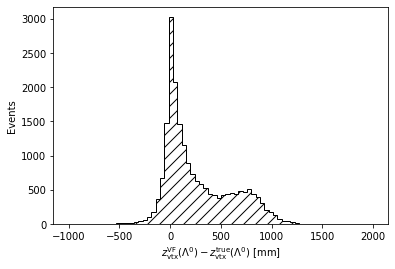

In [29]:
plot_parameters = {
    'binning': 70,
    'x_range': (-1000, 2000),
    'title': '$\Lambda^0$ decay vertex: $z$ bias',
    'x_label': r'$z_\mathrm{vtx}^\mathrm{VF} (\Lambda^0) - z_\mathrm{vtx}^\mathrm{true} (\Lambda^0)$ [mm]',
    'file_name': 'Lambda_endvertex_bias_z',
    'zero_vline': False,
    'log_scale': False,
    'show_title': show_titles,
    'black_and_white': black_and_white,
    'show_grid': show_grid,
}

plot_series_histogram(
    df_mc['L_ENDVERTEX_Z'] - df_mc['MCTRUTH_L_ENDVERTEX_Z'],
    **plot_parameters)

In [54]:
(df_mc['L_ENDVERTEX_Z'] - df_mc['MCTRUTH_L_ENDVERTEX_Z']).std()

673.9864

# Explore "the bump"

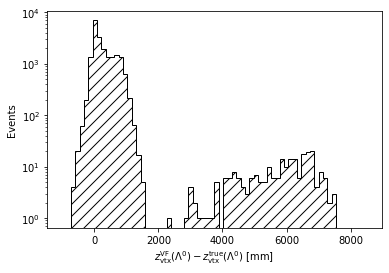

In [31]:
plot_parameters = {
    'binning': 70,
    'x_range': (-1000, 8500),
    'title': '$\Lambda^0$ decay vertex: $z$ bias',
    'x_label': r'$z_\mathrm{vtx}^\mathrm{VF} (\Lambda^0) - z_\mathrm{vtx}^\mathrm{true} (\Lambda^0)$ [mm]',
    'file_name': 'Lambda_endvertex_bias_z_log',
    'zero_vline': False,
    'log_scale': True,
    'show_title': show_titles,
    'black_and_white': black_and_white,
    'show_grid': show_grid,
}

plot_series_histogram(
    df_mc['L_ENDVERTEX_Z'] - df_mc['MCTRUTH_L_ENDVERTEX_Z'],
    **plot_parameters)

In [32]:
bump_min = 2000
bump_max = max(df_mc['L_ENDVERTEX_Z'] - df_mc['MCTRUTH_L_ENDVERTEX_Z'])

bump_cuts = (
    (df_mc['L_ENDVERTEX_Z'] - df_mc['MCTRUTH_L_ENDVERTEX_Z'] >= bump_min)
    & (df_mc['L_ENDVERTEX_Z'] - df_mc['MCTRUTH_L_ENDVERTEX_Z'] <= bump_max)
)

In [33]:
print("Total number of bump events:\t\t", sum(bump_cuts))
print("Fraction of bump events over total:\t", sum(bump_cuts)/sum(pre_selection_cuts))

Total number of bump events:		 233
Fraction of bump events over total:	 0.005042198658299069


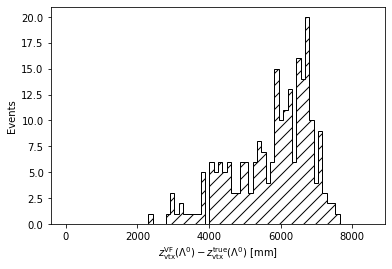

In [34]:
plot_parameters = {
    'binning': 70,
    'x_range': (0, 8500),
    'title': '$\Lambda^0$ decay vertex: $z$ bias',
    'x_label': r'$z_\mathrm{vtx}^\mathrm{VF} (\Lambda^0) - z_\mathrm{vtx}^\mathrm{true} (\Lambda^0)$ [mm]',
    'file_name': 'bump_Lambda_endvertex_bias_z_log',
    'zero_vline': False,
    'log_scale': False,
    'show_title': show_titles,
    'black_and_white': black_and_white,
    'show_grid': show_grid,
}

plot_series_histogram(
    (df_mc['L_ENDVERTEX_Z'] - df_mc['MCTRUTH_L_ENDVERTEX_Z']).loc[bump_cuts],
    **plot_parameters)

In [53]:
(df_mc['L_ENDVERTEX_Z'] - df_mc['MCTRUTH_L_ENDVERTEX_Z']).loc[bump_cuts].median()

6037.402

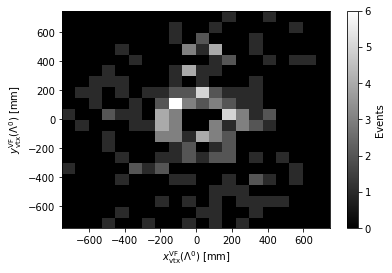

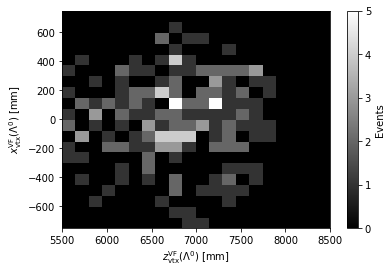

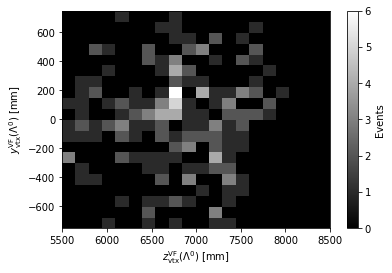

In [35]:
component_to_x_range = {
    'x': [-750, 750],
    'y': [-750, 750],
    'z': [5500,8500]
}

for comp_x, comp_y in [('x', 'y'), ('z', 'x'), ('z', 'y')]:
    plot_parameters = {
        'binning': 20,
        'range_x': component_to_x_range[comp_x],
        'range_y': component_to_x_range[comp_y],
        'title': '$\Lambda^0$ decay vertex: reconstructed $' + comp_x + '$ vs. $' + comp_y + '$',
        'label_x': r'$' +  comp_x + '_\mathrm{vtx}^\mathrm{VF} (\Lambda^0)$ [mm]',
        'label_y': r'$' +  comp_y + '_\mathrm{vtx}^\mathrm{VF} (\Lambda^0)$ [mm]',
        'file_name': 'bump_hist2d_Lambda_endvertex_' + comp_x + '_vs_' + comp_y,
        'show_title': show_titles,
        'black_and_white': black_and_white,
    }
    
    plot_series_hist2d(
        df_mc.loc[bump_cuts, 'L_ENDVERTEX_' + comp_x.upper()],
        df_mc.loc[bump_cuts, 'L_ENDVERTEX_' + comp_y.upper()],
        **plot_parameters
    )

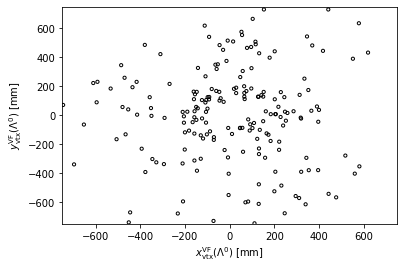

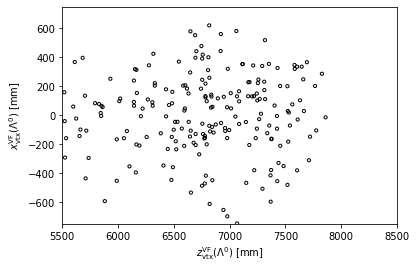

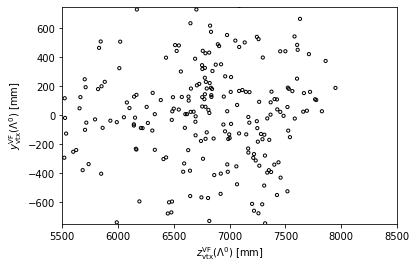

In [36]:
component_to_x_range = {
    'x': [-750, 750],
    'y': [-750, 750],
    'z': [5500,8500]
}

for comp_x, comp_y in [('x', 'y'), ('z', 'x'), ('z', 'y')]:
    plot_parameters = {
        'range_x': component_to_x_range[comp_x],
        'range_y': component_to_x_range[comp_y],
        'title': '$\Lambda^0$ decay vertex: reconstructed $' + comp_x + '$ vs. $' + comp_y + '$',
        'label_x': r'$' +  comp_x + '_\mathrm{vtx}^\mathrm{VF} (\Lambda^0)$ [mm]',
        'label_y': r'$' +  comp_y + '_\mathrm{vtx}^\mathrm{VF} (\Lambda^0)$ [mm]',
        'file_name': 'bump_scatter_Lambda_endvertex_' + comp_x + '_vs_' + comp_y,
        'show_title': show_titles,
        'black_and_white': black_and_white,
    }
    
    plot_series_scatter(
        df_mc.loc[bump_cuts, 'L_ENDVERTEX_' + comp_x.upper()],
        df_mc.loc[bump_cuts, 'L_ENDVERTEX_' + comp_y.upper()],
        **plot_parameters
    )

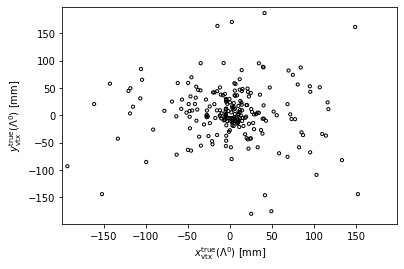

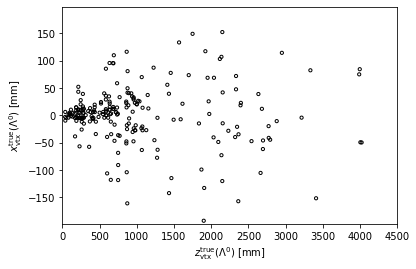

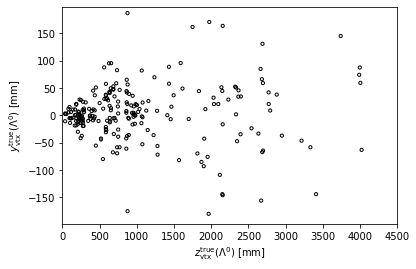

In [37]:
component_to_x_range = {
    'x': [-199, 199],
    'y': [-199, 199],
    'z': [0,4500]
}

for comp_x, comp_y in [('x', 'y'), ('z', 'x'), ('z', 'y')]:
    plot_parameters = {
        'range_x': component_to_x_range[comp_x],
        'range_y': component_to_x_range[comp_y],
        'title': '$\Lambda^0$ decay vertex: true $' + comp_x + '$ vs. $' + comp_y + '$',
        'label_x': r'$' +  comp_x + '_\mathrm{vtx}^\mathrm{true} (\Lambda^0)$ [mm]',
        'label_y': r'$' +  comp_y + '_\mathrm{vtx}^\mathrm{true} (\Lambda^0)$ [mm]',
        'file_name': 'bump_Lambda_true_endvertex_' + comp_x + '_vs_' + comp_y,
        'show_title': show_titles,
        'black_and_white': black_and_white,
    }
    
    plot_series_scatter(
        df_mc.loc[bump_cuts, 'MCTRUTH_L_ENDVERTEX_' + comp_x.upper()],
       df_mc.loc[bump_cuts, 'MCTRUTH_L_ENDVERTEX_' + comp_y.upper()],
        **plot_parameters
    )

# Link between horizontality and bias

## Add magnet polarity information
See `magnet_polarity_derivation` notebook in `lambda-emdm-measurement` repository to understand.

In [38]:
mag_down_bins = [(0, 1730000), (3500000, 4860000), (6200000, 7570000)]
mag_up_bins =  [(1730000, 3500000), (4860000, 6200000), (7570000, 10000000)]

for mag_bin in mag_up_bins:
    df_mc.loc[(df_mc['MC_key'] >= mag_bin[0]) & (df_mc['MC_key'] < mag_bin[1]), 'Polarity'] = +1
    
for mag_bin in mag_down_bins:
    df_mc.loc[(df_mc['MC_key'] >= mag_bin[0]) & (df_mc['MC_key'] < mag_bin[1]), 'Polarity'] = -1

### Prefilter

"Horizontality" is a measure of how "horizontal" the decay plane is, i.e. its angle with the xz curving plane. Useful to check if events have been reconstructed "upside down".

In [39]:
def row_a_vec(row, p_pvec_column, pim_pvec_column):
    return np.cross(row[p_pvec_column], row[pim_pvec_column])

In [40]:
def row_a_norm(row, avec_column):
    return np.linalg.norm(row[avec_column])

In [41]:
def feature_component(series, component):
    return series.map(lambda x: x[component])

In [42]:
## This computes (once) a new column in df named 'momenta_prefix_h',
## containing the related horizontality. Returns the related column name.
def compute_horizontality(
    df: pd.DataFrame,
    momenta_prefix: str,
    p_px_column: str,
    p_py_column: str,
    p_pz_column: str,
    pim_px_column: str,
    pim_py_column: str,
    pim_pz_column :str,
):
      
    p_pvec_column = momenta_prefix + "_p_p_vec"
    pim_pvec_column = momenta_prefix + "_pim_p_vec"
    avec_column = momenta_prefix + "_a_vec"
    anorm_column = momenta_prefix + "_a_norm"
    ahat_column = momenta_prefix + "_a_hat"
    h_column = momenta_prefix + "_h"
    
    df[p_pvec_column] = list(zip(df[p_px_column], df[p_py_column], df[p_pz_column]))
    df[pim_pvec_column] = list(zip(df[pim_px_column], df[pim_py_column], df[pim_pz_column]))
    df[avec_column] = df.apply(lambda row: row_a_vec(row, p_pvec_column, pim_pvec_column), axis=1)
    df[anorm_column] = df.apply(lambda row: row_a_norm(row, avec_column), axis=1)
    df[ahat_column] = df[avec_column]/df[anorm_column]
    df[h_column] = feature_component(df[ahat_column], 1) * df['Polarity'] * np.sign(df['L_ID'])
    
    df.drop(columns=[
        p_pvec_column,
        pim_pvec_column,
        avec_column,
        anorm_column,
        ahat_column
    ], inplace=True)
    
    return h_column

In [43]:
h_reco_DTF = compute_horizontality(
    df=df_mc, momenta_prefix="DTF_FixJPsiLambda",
    p_px_column='DTF_FixJPsiLambda_p_PX', p_py_column='DTF_FixJPsiLambda_p_PY', p_pz_column='DTF_FixJPsiLambda_p_PZ',
    pim_px_column='DTF_FixJPsiLambda_pim_PX', pim_py_column='DTF_FixJPsiLambda_pim_PY', pim_pz_column='DTF_FixJPsiLambda_pim_PZ'
)

In [44]:
h_truth = compute_horizontality(
    df=df_mc, momenta_prefix="MCTRUTH",
    p_px_column='MCTRUTH_p_PX', p_py_column='MCTRUTH_p_PY', p_pz_column='MCTRUTH_p_PZ',
    pim_px_column='MCTRUTH_pim_PX', pim_py_column='MCTRUTH_pim_PY', pim_pz_column='MCTRUTH_pim_PZ'
)

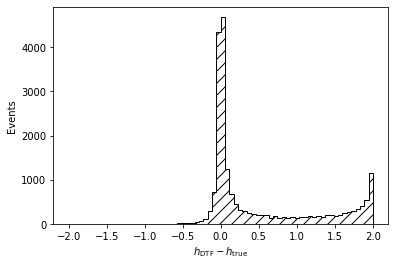

In [45]:
plot_parameters = {
    'binning': 70,
    'x_range': (-2, 2),
    'title': r'$\Lambda^0 \rightarrow p\pi^-$ horizontality bias',
    'x_label': '$h_\mathrm{DTF} - h_\mathrm{true}$',
    'file_name': 'Lambda_horizontality_bias',
    'zero_vline': False,
    'log_scale': False,
    'show_title': show_titles,
    'black_and_white': black_and_white,
    'show_grid': show_grid,
}

plot_series_histogram(
    df_mc[h_reco_DTF] - df_mc[h_truth],
    **plot_parameters)

Fraction of events (passing prefilters) reconstructed with $h$ bias $\geq 1$ ("upside down").

In [46]:
upside_down_individual_cut = df_mc[h_reco_DTF] - df_mc[h_truth] > 1

In [47]:
sum(upside_down_individual_cut) / len(df_mc)

0.24795349963671592

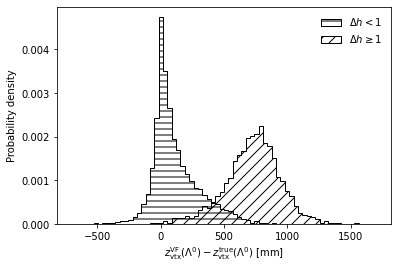

In [48]:
## Common plot parameters
common_plot_params = {
    'range': (-700,1700),
    'bins': 70,
    'histtype': 'stepfilled',
    'edgecolor': 'black',
    'facecolor': 'none',
    'density': True
}

## Individual plot parameters
right_way_up_params = {
    'hatch': '--',
    'label': '$\Delta h < 1$'
}

upside_down_params = {
    'hatch': '//',
    'label': '$\Delta h \geq 1$'
}

series = df_mc['L_ENDVERTEX_Z'] - df_mc['MCTRUTH_L_ENDVERTEX_Z']

## Bias < 1
plt.hist(series.loc[~upside_down_individual_cut], **common_plot_params, **right_way_up_params)

## Bias >= 1
plt.hist(series.loc[upside_down_individual_cut], **common_plot_params, **upside_down_params)

if show_grid:
    plt.grid()

plt.xlabel(r'$z_\mathrm{vtx}^\mathrm{VF} (\Lambda^0) - z_\mathrm{vtx}^\mathrm{true} (\Lambda^0)$ [mm]')
plt.ylabel("Probability density")

if show_titles:
    plt.title(r'$\Lambda^0 \rightarrow p\pi^-$: $z$ vertex bias vs. horizontality bias' + '\n(MC simulation)')

plt.legend(frameon=False)
    
if save_plots:
    plt.savefig(plot_directory + 'lambda_endvertex_z_bias_vs_horizontality_bias' + '.pdf', bbox_inches = 'tight')

plt.show()

In [56]:
(df_mc['L_ENDVERTEX_Z'] - df_mc['MCTRUTH_L_ENDVERTEX_Z']).loc[~upside_down_individual_cut].median()

64.333496